![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FGenerate&file=Vertex+AI+Imagen+For+Image+Generation.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FGenerate%2FVertex%2520AI%2520Imagen%2520For%2520Image%2520Generation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Generate/Vertex%20AI%20Imagen%20For%20Image%20Generation.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Imagen For Image Generation

Generate images with text prompts with [Imagen on Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview).  This workflow walks through generating images from text prompt as well as creating and checking watermarks and saving and loading images.

Additional image task are covered as also:
- Editing Images with Imagen 2.
- Caption Images
- Visual Question Answering

**References:**
- [Vertex AI Imagen API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/imagen-api)
- [Vertex AI Gemini API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/inference)

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.66.0'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'imagen'

packages:

In [264]:
import os
import json
import base64, io

import matplotlib.pyplot as plt

from google.cloud import aiplatform
import vertexai.generative_models # for Gemini Models

In [14]:
aiplatform.__version__

'1.66.0'

clients:

In [15]:
vertexai.init(project = PROJECT_ID, location = REGION)

Parameters:

In [16]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [17]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Text For Examples

Vertex AI hosts many [Google models](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models) as an API.  It also host partner models and offers managed services for hosting private models as well as training models with a full suite of [MLOps capabilities](../../MLOps/readme.md).  This section uses the [Vertex AI Gemini API](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/inference) which is covered in much more depth in [this workflow](./Vertex%20AI%20Gemini%20API.ipynb).

**Task:** Generate a set of text samples to use in prompts for image generation.

In [113]:
llm = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-001")

In [114]:
response_schema = {
    'type': 'OBJECT',
    'properties': {
        'name': {'type': 'STRING'},
        'description': {'type': 'STRING'},
        'breeds': {
            'type': 'ARRAY',
            'items' : {
                'type': 'OBJECT',
                'properties': {
                    'name': {'type': 'STRING'},
                    'physical_description': {'type': 'STRING'},
                    'unique_characteristics': {'type': 'STRING'}
                }
            }
        }
    }
}

In [115]:
groups = ['sporting', 'hound', 'working', 'terrior', 'toy', 'non-sporting', 'herding']

In [120]:
responses = await asyncio.gather(*[
    llm.generate_content_async(
        [
            f'Make a list of dog breeds for the {group}.',
            'Include the following for the group: name and description.'
            'Include the follow for each breed: name, description, unique physical characteristics.'
            #'nclude breeds and varieties in the group from the 212 breeds and varieties recognized by the AKC.'
        ],
        generation_config = vertexai.generative_models.GenerationConfig(
            temperature = 0.0,
            max_output_tokens = 8192,
            response_mime_type = 'application/json',
            response_schema = response_schema
        )
    ) for group in groups
])

In [121]:
breed_data = [json.loads(response.text) for response in responses]

In [122]:
breed_data[0]['name']

'Sporting'

In [123]:
breed_data[0]['description']

'Sporting dogs are a group of dogs that were originally bred for hunting. They are known for their athleticism, intelligence, and trainability. Sporting dogs are often used in hunting birds, small game, and big game.'

In [124]:
len(breed_data[0]['breeds'])

19

In [126]:
[breed['name'] for breed in breed_data[0]['breeds']]

['Afghan Hound',
 'American Foxhound',
 'Basset Hound',
 'Beagle',
 'Bloodhound',
 'Brittany',
 'Cocker Spaniel',
 'English Cocker Spaniel',
 'English Springer Spaniel',
 'Field Spaniel',
 'German Shorthaired Pointer',
 'German Wirehaired Pointer',
 'Irish Red Setter',
 'Irish Water Spaniel',
 'Labrador Retriever',
 'Pointer',
 'Rhodesian Ridgeback',
 'Weimaraner',
 'Wirehaired Pointing Griffon']

In [135]:
breed_data[0]['breeds'][0]['name']

'Afghan Hound'

In [136]:
breed_data[0]['breeds'][0]['physical_description']

'The Afghan Hound is a tall, slender dog with a long, silky coat. They have a distinctive, proud head carriage and a long, flowing tail.'

In [137]:
breed_data[0]['breeds'][0]['unique_characteristics']

'Known for their independent nature and aloofness, Afghan Hounds are also known for their speed and agility. They are often used in sighthound racing.'

___
## Generate Images

Start by loading the image models and tools.  Compare [Imagen model versions here](https://cloud.google.com/vertex-ai/generative-ai/docs/image/model-versioning#img-gen-model).

In [199]:
from vertexai.preview.vision_models import ImageGenerationModel
from vertexai.preview.vision_models import Image
from vertexai.preview.vision_models import WatermarkVerificationModel

In [356]:
imagen3 = ImageGenerationModel.from_pretrained('imagen-3.0-generate-001')
imagen2 = ImageGenerationModel.from_pretrained('imagegeneration@006')
imagen1 = ImageGenerationModel.from_pretrained('imagegeneration@002')

---
### Single Image From Prompt

In [357]:
single_response = imagen3.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 1,
    language = 'en',
    aspect_ratio = '1:1',
)

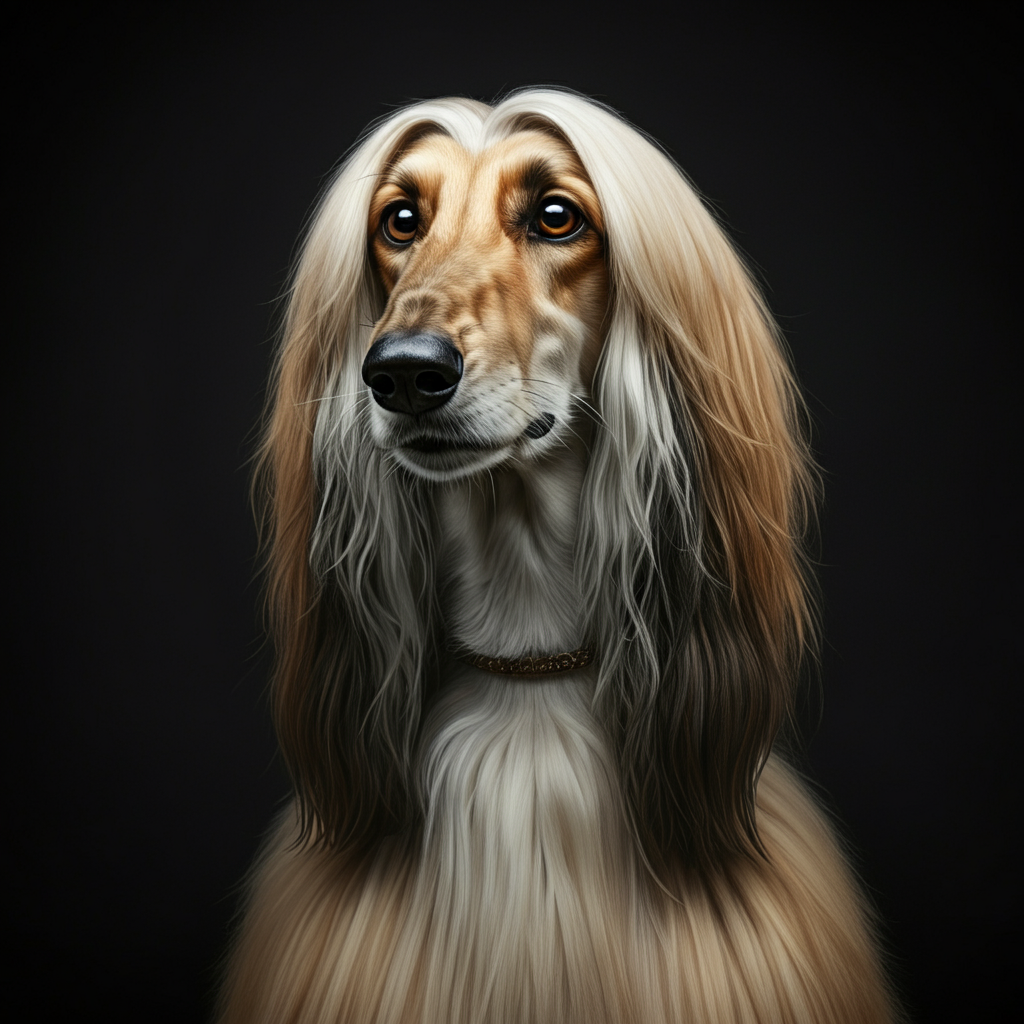

In [358]:
single_response[0].show()

#### Examine Response Object

Above the response object was used to directly display the generated image.  Similarly, the response object can be directly saved to a file as will be shown later.  This section examine the response object along with its attributed to recall the raw image information in different formats.

**Reference**
- [SDK Reference for `vertexai.vision_models`](https://github.com/googleapis/python-aiplatform/blob/main/vertexai/vision_models/_vision_models.py)

In [359]:
type(single_response)

vertexai.preview.vision_models.ImageGenerationResponse

In [360]:
type(single_response.images)

list

In [361]:
type(single_response.images[0])

vertexai.preview.vision_models.GeneratedImage

In [362]:
type(single_response[0])

vertexai.preview.vision_models.GeneratedImage

In [363]:
type(single_response.images[0].generation_parameters)

dict

In [364]:
type(single_response.images[0]._pil_image)

PIL.PngImagePlugin.PngImageFile

In [365]:
type(single_response.images[0]._image_bytes)

bytes

---
### Multiple Images From Prompt

In [366]:
multi_response = imagen3.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 4,
    language = 'en',
    aspect_ratio = '1:1',
)

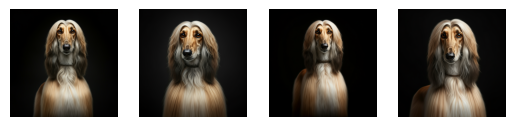

In [367]:
fix, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(multi_response.images[i]._pil_image)
    ax[i].axis('off')
plt.show()

---
### Save Images

With the SDK an image can be directly saved with the `.save()` method and results in a PNG file.  The included `._pil_image` info can be used with the PIL SDK to save in additional formats - JPEG shown below.

In [368]:
single_response.images[0].save(location = f"{DIR}/image_0_0.png")

In [369]:
#os.listdir(DIR)

In [370]:
single_response.images[0]._pil_image.save(fp = f"{DIR}/image_0_0.jpeg", format = 'JPEG')

In [371]:
#os.listdir(DIR)

---
### Load Image

Loading image can be useful for the editing capabilities of Imagen as well as for verfiying the watermark of generated image.  The Imagen SDK offer an `Image` method than can load from either image bytes or a GCS Uri. It also includes a `.load_from_file` method to load local files.  These are shown here:

#### With `Image` using `image_bytes=` or `gcs_uri=`:

In [372]:
image = Image(image_bytes = single_response.images[0]._image_bytes) # or gcs_uri = ''
type(image)

vertexai.vision_models.Image

#### With `Image.load_from_file` for different file types:

In [373]:
image = Image.load_from_file(location = f"{DIR}/image_0_0.png")
type(image)

vertexai.vision_models.Image

In [374]:
image = Image.load_from_file(location = f"{DIR}/image_0_0.jpeg")
type(image)

vertexai.vision_models.Image

---
### Watermark Image

The Imagen image generation include non-visable watermarks by default.  The SDK can also be used to verify the watermark of an image.

**Reference:**
- [Add or verify an image watermark](https://cloud.google.com/vertex-ai/generative-ai/docs/image/generate-images#watermark)

In [375]:
verification_model = WatermarkVerificationModel.from_pretrained("imageverification@001")

#### For Default Settings Which Include Watermark

The responses, `single_response` and `multi_response`, from earlier in this workflow did not set the `add_watermark` parameter which is defaulted to `True`.  Verify the watermark of the recent responses above:

In [376]:
verification_model.verify_image(single_response.images[0])

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

#### Generate Image without Watermark Using `add_watermark = False`

By opting to not have a watermark the generated image fails verification as expected.

In [404]:
response = imagen3.generate_images(
    prompt = ''.join([
        'Generate an photo realistic image with a black background of a dog with the following characteristics:',
        f"breed group: {breed_data[0]['name']}",
        f"breed group description: {breed_data[0]['description']}",
        f"breed name: {breed_data[0]['breeds'][0]['name']}",
        f"breed description: {breed_data[0]['breeds'][0]['physical_description']}",
        f"unqiue characteristics: {breed_data[0]['breeds'][0]['unique_characteristics']}"
    ]),
    number_of_images = 1,
    language = 'en',
    aspect_ratio = '1:1',
    add_watermark = False
)

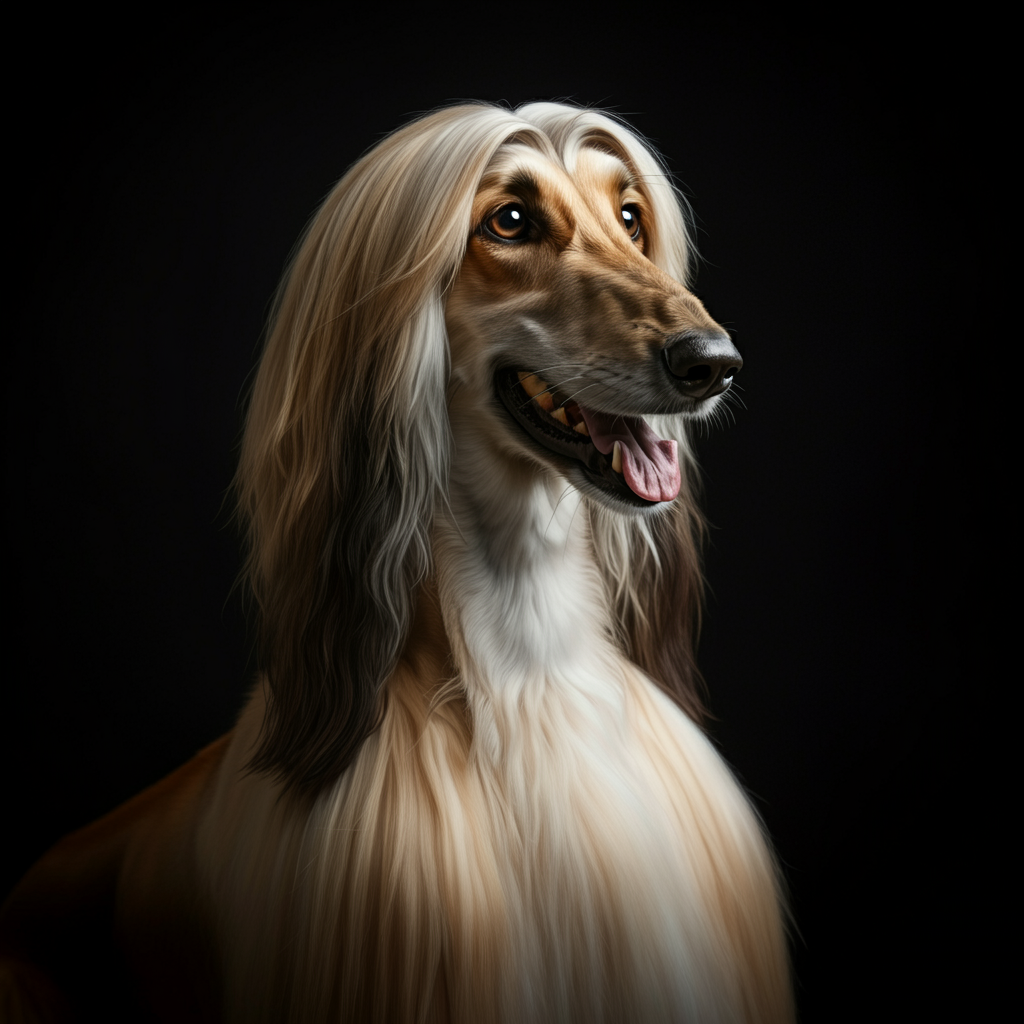

In [405]:
response.images[0].show()

In [406]:
verification_model.verify_image(response.images[0])

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'REJECT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='REJECT')

---
### Check For Watermark

#### Image Saved And Reloaded

In the section above, the image was saved to disk as a `jpeg` and reloaded.  Check this version for the default watermark.

In [380]:
type(image._pil_image)

PIL.JpegImagePlugin.JpegImageFile

In [381]:
verification_model.verify_image(image)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

#### Alter Image And Check Watermark: Change Resolution

The image is still fully intact with just a smaller resolution of the same aspect ratio.  This retains the watermark as verified.

In [389]:
image._pil_image.size

(1024, 1024)

In [390]:
altered_image = image._pil_image.resize((300, 300))

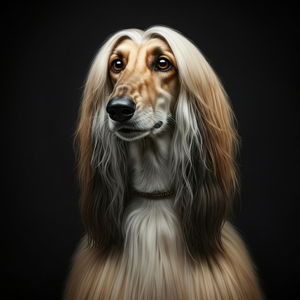

In [391]:
altered_image

In [392]:
with io.BytesIO() as output:
    altered_image.save(output, format='PNG')
    altered_image_bytes = output.getvalue()

In [393]:
altered_image_load = Image(image_bytes = altered_image_bytes)

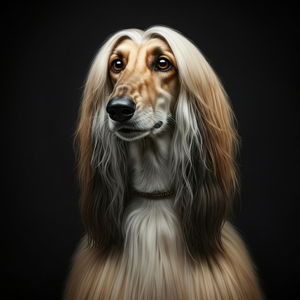

In [394]:
altered_image_load.show()

In [395]:
verification_model.verify_image(altered_image_load)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'ACCEPT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='ACCEPT')

#### Alter Image And Check Watermark: Crop Image

Since cropping removes portion of the generated image it will fail a verfication check for watermark.

In [396]:
altered_image = altered_image.crop((100, 100, 200, 200))

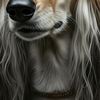

In [397]:
altered_image

In [398]:
with io.BytesIO() as output:
    altered_image.save(output, format='PNG')
    altered_image_bytes = output.getvalue()

In [399]:
altered_image_load = Image(image_bytes = altered_image_bytes)

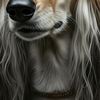

In [400]:
altered_image_load.show()

In [401]:
verification_model.verify_image(altered_image_load)

WatermarkVerificationResponse(_prediction_response=Prediction(predictions=[{'decision': 'REJECT'}], deployed_model_id='', metadata=None, model_version_id='', model_resource_name='', explanations=None), watermark_verification_result='REJECT')

---
## Generate Many Images

In the `Text For Examples` section at the top of this workflow Gemini was used to create descriptions for many dog breeds.  What if we wanted to generate images for each breed using a similar prompt but just inserting the generated names and descriptions?  The following code sequentially generates an image for each dog breed, saves it to local folder, and adds the image file name to the `breed_data`.

There are default limits to the number of request per minute that can be made for each model type hosted on Vertex AI.  For Imagen this is 100 in the region being used by this notebook.  Verify the limits for your choice of model and region as well as get instructions for requesting an increase:[Quotas by region and model](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#quotas_by_region_and_model). 

The following code makes sequential requests and while the total requests exceeds the rate limit of 100 the several seconds of generation time prevents exceeding 100 per minute. In practice, it would be helpful to add error detection and retries to this type of routine.

In [294]:
for g, group in enumerate(breed_data):
    for b, breed in enumerate(group['breeds']):

        response = imagen3.generate_images(
            prompt = ''.join([
                'Generate an photo realistic image with a black background of a dog with the following characteristics:',
                f"breed group: {group['name']}",
                f"breed group description: {group['description']}",
                f"breed name: {breed['name']}",
                f"breed description: {breed['physical_description']}",
                f"unqiue characteristics: {breed['unique_characteristics']}"
            ]),
            number_of_images = 1,
            language = 'en',
            aspect_ratio = '1:1',
        )
        image = response.images[0]._pil_image.resize((300, 300))
        image.save(fp = f"{DIR}/image_{g}_{b}.png", format = 'PNG')
        breed_data[g]['breeds'][b]['image'] = f'image_{g}_{b}.png'

In [296]:
os.listdir(DIR)[0:10]

['image_3_16.png',
 'image_3_7.png',
 'image_3_1.png',
 'image_0_5.png',
 'image_6_12.png',
 'image_0_15.png',
 'image_5_13.png',
 'image_1_11.png',
 'image_3_2.png',
 'image_5_7.png']

### Save Data To Directory

Create a local file of JSONL from the `breed_data` generated here:

In [297]:
with open(f'{DIR}/breed-data.jsonl', 'w') as f:
    for group in breed_data:
        f.write(json.dumps(group)+ '\n')

In [403]:
#os.listdir(DIR)

---
## Edit Images

What if you have an image and want to edit it? 

With Imagen 2 you can  do the followiong types of editing:

- Inpainting - add or remove content from an image area using:
    - A mask file provided to the SDK or created in the console
    - A text prompt describing the area to edit: sky, ground, background, etc.
- Outpainting - Expand content for an image to a large area includinng different shapes
- Segmentation - Identify objects and change the surrounding content
- Controlled Editing - change the style of images
- Personalization - style images of faces in predefined styles like watercolor, hand drawing, illustation, and 3D character

Simlarly, with Imagen 1 you can do mask-free edits :
- Open Editing - mask or mask free  edits

[The documentation](https://cloud.google.com/vertex-ai/generative-ai/docs/image/overview) provides deeper guidance of prompting for style and content. A brief overview of editing with Imagen 2 is provided here below.

### The Base Image

Start with a base image, like the one loaded above or one generated by a previous generation request.

In [410]:
type(image)

vertexai.vision_models.Image

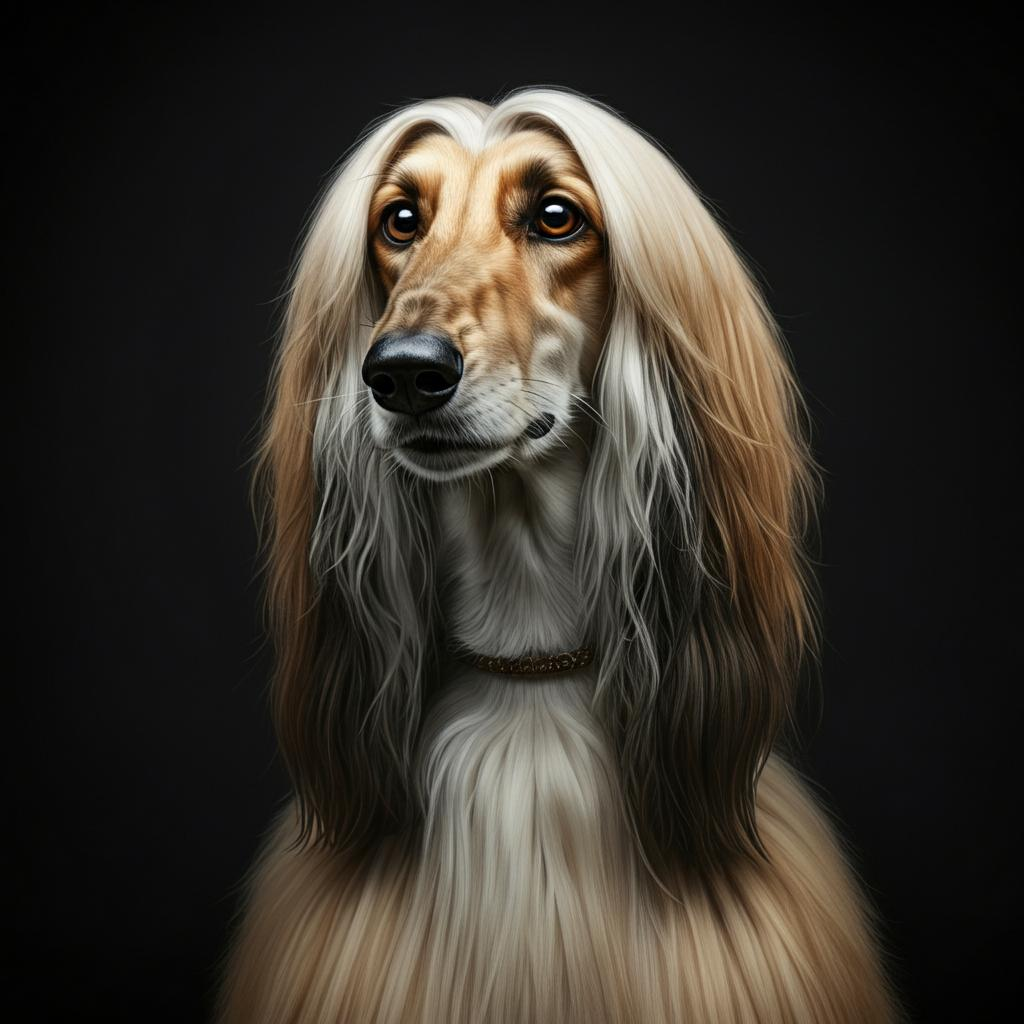

In [411]:
image.show()

### Inpainting With Prompt Mask: Insert Content

In [419]:
insert_response = imagen2.edit_image(
    base_image = image,
    mask_mode = 'background',
    prompt = 'an ornate living room scene with victorian furniture and decorations including vases on a mantel above a fireplace',
    edit_mode = 'inpainting-insert'
)

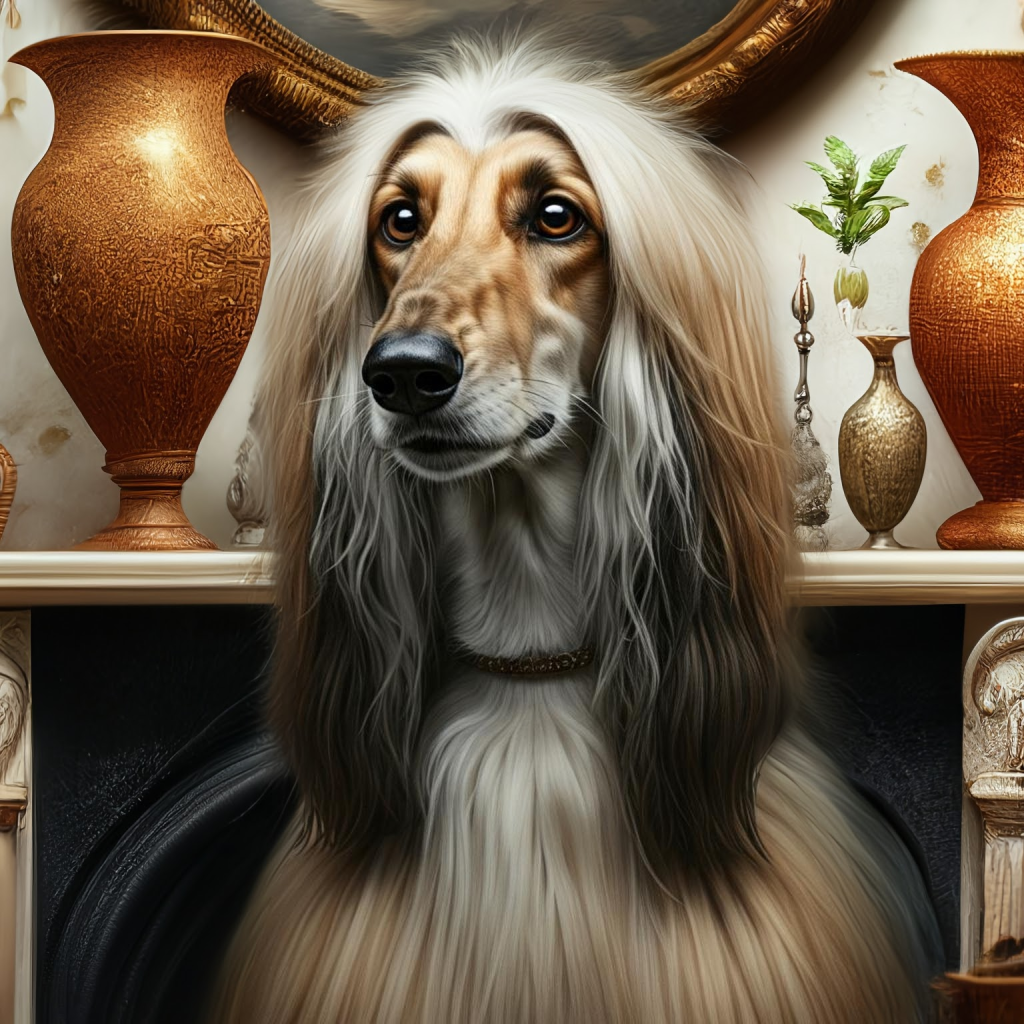

In [420]:
insert_response.images[0].show()

### Inpainting With Prompt Mask: Remove Content

In [423]:
remove_response = imagen2.edit_image(
    base_image = insert_response.images[0],
    mask_mode = 'semantic', # semantic requires setting the segmentation_class
    segmentation_classes = [106], # 106 is the class id for vase
    prompt = 'Change the vases on the mantel to be modern, like popart style',
    edit_mode = 'inpainting-remove'
)

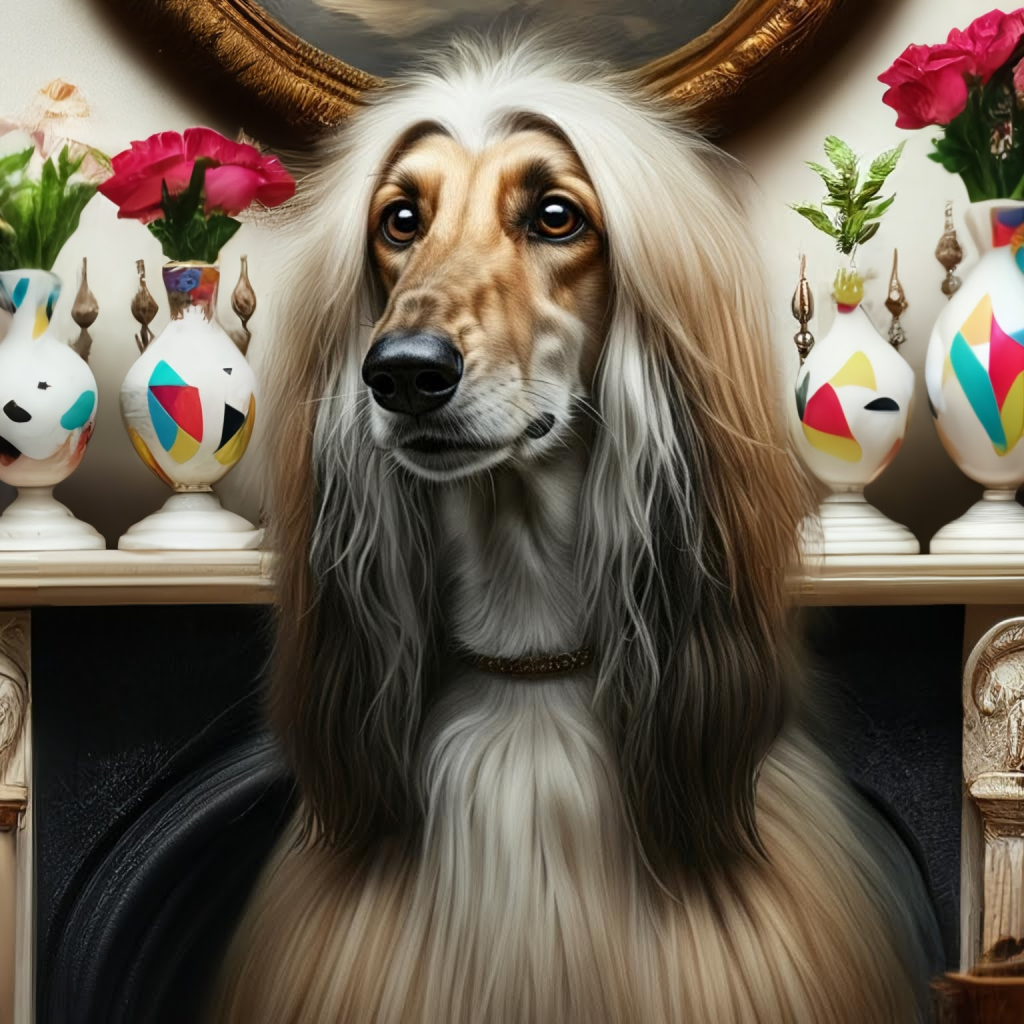

In [424]:
remove_response.images[0].show()

---
## Image Captioning

---
## Visual Q&A